# Benchmarking QAOA and VQE solutions to the mean variance portfolio problem with real data

In [413]:
from qiskit import Aer
from qiskit.circuit.library import TwoLocal
from qiskit.aqua import QuantumInstance
from qiskit.finance.applications.ising import portfolio
from qiskit.finance import QiskitFinanceError
from qiskit.finance.data_providers import *
from qiskit.optimization.applications.ising.common import sample_most_likely
from qiskit.finance.data_providers import RandomDataProvider
from qiskit.aqua.algorithms import VQE, QAOA, NumPyMinimumEigensolver
from qiskit.aqua.components.optimizers import COBYLA
import numpy as np
import matplotlib.pyplot as plt
import datetime
import json
import http.client

In [489]:
def get_vars(stocks, risk_factor):
    data = YahooDataProvider(tickers = stocks, start=datetime.datetime(2013, 1, 1), end=datetime.datetime(2020, 1, 1))
    data.run()
    # set number of equities to the number of stocks, num_assets = qubits
    num_assets = len(stocks)
    mu = data.get_period_return_mean_vector()
    sigma = data.get_period_return_covariance_matrix()
    
    # Covariant matrix plot -- shows correlation between equities
    print("Covariance plot")
    plt.imshow(sigma)
    plt.show()
    
    # set the risk factor
    q = risk_factor
    # set budget
    budget = num_assets // 2 
    # scaling of budget penalty term will be dependant on the number of assets
    penalty = num_assets 
    
    # Retrieve Hamiltonian
    qubitOp, offset = portfolio.get_operator(mu, sigma, q, budget, penalty)
    
    return num_assets, mu, sigma, q, budget, penalty, qubitOp, offset

## Data processing functions

In [479]:
def index_to_selection(i, num_assets):
    s = "{0:b}".format(i).rjust(num_assets)
    x = np.array([1 if s[i]=='1' else 0 for i in reversed(range(num_assets))])
    return x

def selection_to_picks(num_assets, selection):
    purchase = []
    for i in range(num_assets):
        if selection[i] == 1:
            purchase.append(stocks[i])
    return purchase

def print_result(result):
    selection = sample_most_likely(result.eigenstate)
    value = portfolio.portfolio_value(selection, mu, sigma, q, budget, penalty)
    print(f"!!! Optimal: portfolio holdings !!!")
    return selection

## QAOA implementation

In [495]:
def qaoa(qubitOp):
    backend = Aer.get_backend('statevector_simulator')
    seed = 50
    cobyla = COBYLA()
    cobyla.set_options(maxiter=250)
    qaoa = QAOA(qubitOp, cobyla, 3)

    qaoa.random_seed = seed
    quantum_instance = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed)
    results= qaoa.run(quantum_instance)
    selection = print_result(results)
    print(selection_to_picks(num_assets, selection))

## Classical Benchmark

In [496]:
def numpyEigensolver(qubitOp):
    selections = []
    exact_eigensolver = NumPyMinimumEigensolver(qubitOp)
    result = exact_eigensolver.run()

    selection_1 = print_result(result)
    print(selection_to_picks(num_assets, selection_1))

## VQE 

In [497]:
def vqe(qubitOp):
    backend = Aer.get_backend('statevector_simulator')
    seed = 50

    cobyla = COBYLA()
    cobyla.set_options(maxiter=500)
    ry = TwoLocal(qubitOp.num_qubits, 'ry', 'cz', reps=3, entanglement='full')
    vqe = VQE(qubitOp, ry, cobyla)
    vqe.random_seed = seed

    quantum_instance = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed)

    result = vqe.run(quantum_instance)

    selection_2 = print_result(result)
    print(selection_to_picks(num_assets, selection_2))

## Benchmarking

Covariance plot


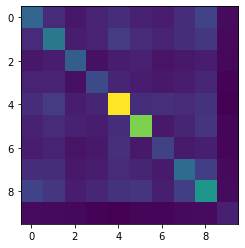

In [483]:
###INSERT STOCK TICKERS IN STOCKS ARRAY ###
stocks = ["MSFT", "BA", "CVS", "IBM", "CF", "BIIB", "XOM", "V", "ADBE", "PEP"]
###---###
num_assets, mu, sigma, q, budget, penalty, qubitOp, offset = get_vars(stocks, 0.7)

In [486]:
#Classical Benchmark
numpyEigensolver(qubitOp)

!!! Optimal: portfolio holdings !!!
['MSFT', 'BA', 'V', 'ADBE', 'PEP']


In [487]:
# VQE
vqe(qubitOp)

!!! Optimal: portfolio holdings !!!
['CVS', 'BIIB', 'XOM', 'ADBE', 'PEP']


In [485]:
# QAOA
qaoa(qubitOp)

!!! Optimal: portfolio holdings !!!


## Comparing results from all approaches
![](./Trial_1.png)

# Another trial

Covariance plot


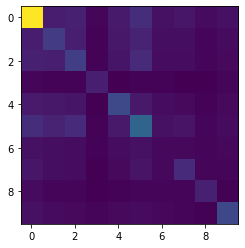

In [490]:
###INSERT STOCK TICKERS IN STOCKS ARRAY ###
stocks = ['TSLA', 'MSFT', 'GOOG', 'PFE', 'AAPL', 'AMZN', 'SPY', 'ICLN', 'XOM', 'WBA']
###---###
num_assets, mu, sigma, q, budget, penalty, qubitOp, offset = get_vars(stocks, 0.7)

In [492]:
#Classical Benchmark
numpyEigensolver(qubitOp)

!!! Optimal: portfolio holdings !!!
['TSLA', 'MSFT', 'AAPL', 'AMZN', 'SPY']


In [493]:
# VQE
vqe(qubitOp)

!!! Optimal: portfolio holdings !!!
['MSFT', 'AAPL', 'AMZN', 'SPY', 'XOM']


In [494]:
# QAOA
qaoa(qubitOp)

!!! Optimal: portfolio holdings !!!


![](./Trial_2.png)

# One more trial

Covariance plot


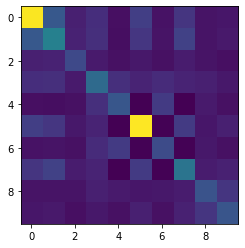

In [504]:
###INSERT STOCK TICKERS IN STOCKS ARRAY ###
stocks = ['ATVI', 'MA', 'MCD', 'PLD', 'ETR', 'HBI', 'NEE', 'JPM', 'VZ', 'T']
###---###
num_assets, mu, sigma, q, budget, penalty, qubitOp, offset = get_vars(stocks, 0.7)

In [505]:
#Classical Benchmark
numpyEigensolver(qubitOp)

!!! Optimal: portfolio holdings !!!
['ATVI', 'MA', 'MCD', 'NEE', 'JPM']


In [506]:
# VQE
vqe(qubitOp)

!!! Optimal: portfolio holdings !!!
['ATVI', 'MCD', 'ETR', 'VZ', 'T']


In [507]:
# QAOA
qaoa(qubitOp)

!!! Optimal: portfolio holdings !!!
['ATVI', 'MA', 'ETR', 'NEE', 'JPM']


![](./Trial_3.png)